# NLP Project - FCIS '23

## About Dataset

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. It was originally collected by Ken Lang, probably for his Newsweeder: Learning to filter netnews paper, though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

https://www.kaggle.com/datasets/amrwael/nlp-project-fcis-23

Dateset link: http://qwone.com/~jason/20Newsgroups/

## Import required packages

In [54]:
import os
import re
from langdetect import detect
import numpy as np
from tqdm import tqdm, trange
import spacy
import en_core_web_sm
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec, Doc2Vec, FastText, TfidfModel
from gensim.models.doc2vec import TaggedDocument
from gensim.corpora import Dictionary
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Split the data

In [2]:
data_path = 'D:/Studia/Wstęp do uczenia maszynowego/Projekt2/20news-19997/20_newsgroups'
train_data = []
valid_data = []

for folder in os.listdir(data_path):
    for idx, file in enumerate(os.listdir(f'{data_path}/{folder}')):
        if idx <= 799:
            f = open(f'{data_path}/{folder}/{file}', 'rb')
            train_data.append(f.read())
        else:
            f = open(f'{data_path}/{folder}/{file}', 'rb')
            valid_data.append(f.read())

## Data Preprocessing

In [3]:
len(train_data), len(valid_data)

(16000, 3997)

In [4]:
print(train_data[0])

b'Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49960 alt.atheism.moderated:713 news.answers:7054 alt.answers:126\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!magnus.acs.ohio-state.edu!usenet.ins.cwru.edu!agate!spool.mu.edu!uunet!pipex!ibmpcug!mantis!mathew\nFrom: mathew <mathew@mantis.co.uk>\nNewsgroups: alt.atheism,alt.atheism.moderated,news.answers,alt.answers\nSubject: Alt.Atheism FAQ: Atheist Resources\nSummary: Books, addresses, music -- anything related to atheism\nKeywords: FAQ, atheism, books, music, fiction, addresses, contacts\nMessage-ID: <19930329115719@mantis.co.uk>\nDate: Mon, 29 Mar 1993 11:57:19 GMT\nExpires: Thu, 29 Apr 1993 11:57:19 GMT\nFollowup-To: alt.atheism\nDistribution: world\nOrganization: Mantis Consultants, Cambridge. UK.\nApproved: news-answers-request@mit.edu\nSupersedes: <19930301143317@mantis.co.uk>\nLines: 290\n\nArchive-name: atheism/resources\nAlt-atheism-archive-name: resources\nLast-

### Convert the data from bytes to the ordinary 'str'

In [5]:
def bytes_to_str(bytes_obj):
    as_list = bytes_obj.split(b'\n')
    as_str = ''
    for i in as_list:
        as_str += i.decode('latin-1') + '\n'
        
    return as_str[:-1]

In [6]:
for i in range(len(train_data)):
    train_data[i] = bytes_to_str(train_data[i])

In [7]:
print(train_data[1])

Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51060 alt.atheism.moderated:727 news.answers:7300 alt.answers:155
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!agate!netsys!ibmpcug!mantis!mathew
From: mathew <mathew@mantis.co.uk>
Newsgroups: alt.atheism,alt.atheism.moderated,news.answers,alt.answers
Subject: Alt.Atheism FAQ: Introduction to Atheism
Summary: Please read this file before posting to alt.atheism
Keywords: FAQ, atheism
Message-ID: <19930405122245@mantis.co.uk>
Date: Mon, 5 Apr 1993 12:22:45 GMT
Expires: Thu, 6 May 1993 12:22:45 GMT
Followup-To: alt.atheism
Distribution: world
Organization: Mantis Consultants, Cambridge. UK.
Approved: news-answers-request@mit.edu
Supersedes: <19930308134439@mantis.co.uk>
Lines: 646

Archive-name: atheism/introduction
Alt-atheism-archive-name: introduction
Last-modified: 5 April 1993
Version: 1.2

-----BEGIN PGP SIGNED MESSAGE-----

                          An Introduction t

### Split into data and info

In [8]:
print(train_data[13])   

Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!noc.near.net!news.centerline.com!uunet!olivea!sgigate!sgiblab!adagio.panasonic.com!nntp-server.caltech.edu!keith
From: keith@cco.caltech.edu (Keith Allan Schneider)
Newsgroups: alt.atheism
Subject: Re: Keith Schneider - Stealth Poster?
Message-ID: <1pi9uoINNqfv@gap.caltech.edu>
Date: 2 Apr 93 21:07:36 GMT
References: <mam.03kh@mouse.cmhnet.org> <1p8rajINNf3n@gap.caltech.edu> <1993Mar30.184909.20567@blaze.cs.jhu.edu> <1pcrriINNrd6@gap.caltech.edu> <1993Mar31.224831.13186@blaze.cs.jhu.edu>
Organization: California Institute of Technology, Pasadena
Lines: 25
NNTP-Posting-Host: punisher.caltech.edu

arromdee@jyusenkyou.cs.jhu.edu (Ken Arromdee) writes:

>>But, if you were to discuss the merits of racism, or its psycholgical
>>benefits, you would do well to have experienced it personally.
>When you speak of "experiencing religion" you mean someone should believe in
>a religi

In [9]:
def get_info(data):
    info = ['' for _ in data]
    for i in range(len(info)):
        info[i], data[i] = data[i].split('\n\n', 1)
    return info, data

In [10]:
train_info, train_data = get_info(train_data)

In [11]:
empty = []
for i in range(len(train_data)):
    match = re.search("\w+", train_data[i])    # we are looking for words
    if not match:
        empty.append(i)
empty.reverse()

### Remove empty articles

In [12]:
print(empty)
for i in empty:
    train_data.pop(i)
    train_info.pop(i)

[11918, 11127, 9935, 8104, 7563, 6756, 6755, 6518, 5994, 5723, 5594, 5143, 4984, 4806, 4239, 3883, 3679, 3382, 2890, 2671, 2664, 2277, 2273, 2264, 1985, 1980, 1979, 873, 828, 816]


### Check if there are more languages than English

In [13]:
languages = []
for text in tqdm(train_data):
    languages.append(detect(text))

100%|███████████████████████████████████████████████████████████████████████████| 15970/15970 [01:58<00:00, 135.21it/s]


In [14]:
languages = np.array(languages)
print(np.unique(languages))

['af' 'ca' 'da' 'de' 'en' 'et' 'fr' 'id' 'it' 'nl' 'pl' 'ro' 'sk' 'so'
 'sq' 'sv' 'tr']


In [15]:
np.unique(languages, return_counts=True)

(array(['af', 'ca', 'da', 'de', 'en', 'et', 'fr', 'id', 'it', 'nl', 'pl',
        'ro', 'sk', 'so', 'sq', 'sv', 'tr'], dtype='<U2'),
 array([    2,     2,     1,    10, 15926,     1,     5,     2,     1,
            5,     1,     7,     1,     1,     1,     3,     1],
       dtype=int64))

In [16]:
fr = np.where(languages == "fr")[0]
fr

array([ 4996,  7145,  9610, 10150, 11872], dtype=int64)

In [17]:
for i in fr:
    print("-"*40)
    print(train_data[i])      # Most of it is mistakes due to how short the text is
    # + ASCII-ART

----------------------------------------


email your replies to:

danj@holonet.net

----------------------------------------

test

----------------------------------------
mdanjou@gel.ulaval.ca (Martin D'Anjou) writes:
B
)>>>>>>>>> Votre host est mal configure... <<<<<<<<<<<<


)Bonjour Sylvain,
)	J'ai travaille avec le hc11 il y a 3 ans et je ne me souviens pas de toutes les possibilites mais je vais quand meme essayer de t'aider.

)	Je ne crois pas que downloader une programme directement dans le eeprom soit une bonne idee (le eeprom a une duree de vie limitee a 10 000 cycles il me semble). Le communication break down vient peut-etre du fait que le eeprom est long a programmer (1ms par 8 bytes mais c'est a verifier) et que les delais de transfer de programme s19 vers la memoire sont excedes. Normalement, les transferts en RAM du code s19 est plus rapide car le RAM est plus rapide que le eeprom en ecriture.

)	C'est tout ce que ma memoire me permet de me souvenir!

)Bonne chance,

O

A significant portion of the text is a quote in French

### Extracting the subject from the text.

In [18]:
subject = []
p = re.compile(r'Subject: .*')
for i in train_info:
    match = re.search(p, i)
    if match:
        subject.append(i[(match.start()+9):match.end()])
    else:
        subject.append('')

In [19]:
print(subject[0])

Alt.Atheism FAQ: Atheist Resources


In [20]:
newsgroups = []
p = re.compile(r'Newsgroups: .*')
for i in train_info:
    match = re.search(p, i)
    if match:
        ns = i[(match.start()+12):match.end()].split(",")
        newsgroups.append(ns)
    else:
        newsgroups.append([])

In [21]:
print(newsgroups[1000])

['comp.graphics']


In [22]:
print(train_data[1000])
print('-'*40)
print(train_info[1000])


	Hi, I'm looking for the 3-D studio driver for the
	Oak card with 1 M of RAM.
	This would be GREATLY (and I mean that) appreciated

	Maybe I should have just gotten a more well know card.
thanks
seth@acpub.duke.edu

----------------------------------------
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!gatech!concert!duke!news.duke.edu!north1.acpub.duke.edu!seth
From: seth@north1.acpub.duke.edu (Seth Wandersman)
Newsgroups: comp.graphics
Subject: Oak Driver NEEDED (30d studio)
Message-ID: <13412@news.duke.edu>
Date: 16 Apr 93 22:15:30 GMT
Sender: news@news.duke.edu
Reply-To: seth@north1.acpub.duke.edu (Seth Wandersman)
Lines: 8
Nntp-Posting-Host: north1.acpub.duke.edu


### Quotes and signatures at the end of the article

In [23]:
from sklearn.preprocessing import LabelEncoder
newsgroups = [n[0].strip() for n in sorted(newsgroups, key=len)]

In [24]:
np.unique(newsgroups) 

array(['5col.forsale', 'ak.general', 'alt.3d', 'alt.activism',
       'alt.activism.d', 'alt.artcom', 'alt.atheism', 'alt.autos',
       'alt.bbs.ads', 'alt.binaries.pictures',
       'alt.binaries.pictures.supermodels',
       'alt.binaries.pictures.utilities', 'alt.cd-rom',
       'alt.chinese.text', 'alt.config', 'alt.conspiracy',
       'alt.discrimination', 'alt.drugs', 'alt.fan.bill-gates',
       'alt.fan.rush-limbaugh', 'alt.feminism', 'alt.flame',
       'alt.folklore.computers', 'alt.folklore.urban', 'alt.graphics',
       'alt.graphics.pixutils', 'alt.history.what-if',
       'alt.internet.services', 'alt.journalism', 'alt.law-enforcement',
       'alt.magick', 'alt.messianic', 'alt.mythology', 'alt.news-media',
       'alt.pagan', 'alt.parents-teens', 'alt.politics.clinton',
       'alt.politics.italy', 'alt.politics.libertarian',
       'alt.politics.radical-left', 'alt.politics.sex',
       'alt.politics.usa.constitution', 'alt.president.clinton',
       'alt.privacy', 'a

In [25]:
p = re.compile(r"(\n|^)\|?\s*>*")
for n, t in enumerate(train_data):
    train_data[n] = re.sub(p, "\n", t)  

In [26]:
# This regex finds the signature at the end of the article.
# Sometimes, this signature contains inspiring quotes unrelated to the topic 
# or frames with characters like "|" and "-". 
# Unnecessary.

p = re.compile(r"(.*(writes:|says:)\n)|(\n-+\s*\n(.|\n)*\Z)|([^'\w\s])")
for n, t in tqdm(enumerate(train_data), desc='regex'):
    train_data[n] = re.sub(p, "", t)

regex: 15970it [00:10, 1456.41it/s]


In [27]:
print(train_data[1000])


Hi I'm looking for the 3D studio driver for the
Oak card with 1 M of RAM
This would be GREATLY and I mean that appreciated
Maybe I should have just gotten a more well know card
thanks
sethacpubdukeedu



## Preprocessing using Spacy

In [28]:
nlp = en_core_web_sm.load()

for i in trange(len(train_data), desc="train"):
    train_data[i] = nlp(train_data[i])

train: 100%|█████████████████████████████████████████████████████████████████████| 15970/15970 [08:26<00:00, 31.54it/s]


In [29]:
train_data[10].ents   # proper names

(a few
 years,
 40 years,
 now than,
 40 years ago)

In [30]:
print(train_data[10])


How long does it the motto have to stay around before it becomes the
default    Where's the cutoff point 
I don't know where the exact cutoff is but it is at least after a few
years and surely after 40 years
Why does the notion of default not take into account changes
in population makeup     
Specifically which changes are you talking about  Are you arguing
that the motto is interpreted as offensive by a larger portion of the
population now than 40 years ago
keith



In [31]:
for token in train_data[10]:   
    print(f"{(token.text if not token.text.isspace() else ''):20s} \
    [{(token.pos_):^7s}]   ---->   {token.lemma_ if not token.lemma_.isspace() else ''}")

                         [ SPACE ]   ---->   
How                      [  ADV  ]   ---->   how
long                     [  ADV  ]   ---->   long
does                     [  AUX  ]   ---->   do
it                       [ PRON  ]   ---->   it
the                      [  DET  ]   ---->   the
motto                    [ NOUN  ]   ---->   motto
have                     [ VERB  ]   ---->   have
to                       [ PART  ]   ---->   to
stay                     [ VERB  ]   ---->   stay
around                   [  ADV  ]   ---->   around
before                   [  ADP  ]   ---->   before
it                       [ PRON  ]   ---->   it
becomes                  [ VERB  ]   ---->   become
the                      [  DET  ]   ---->   the
                         [ SPACE ]   ---->   
default                  [ NOUN  ]   ---->   default
                         [ SPACE ]   ---->   
Where                    [  ADV  ]   ---->   where
's                       [  AUX  ]   ---->   be
the           

### Remove puctuation marks, space & stop words

In [32]:
to_remove = ['X', 'NUM', 'SYM']

def remove_stop(data):
    for i in tqdm(range(len(data))):
        text = []
        for w in data[i]:
            if not w.is_stop and not w.is_space and not w.is_punct and not w.pos_ in to_remove:
                text.append(w.lemma_)
        data[i] = text
    return data

train_data = remove_stop(train_data)

100%|██████████████████████████████████████████████████████████████████████████| 15970/15970 [00:02<00:00, 6599.18it/s]


In [33]:
print(train_data[12])

['patently', 'untrue', 'demonstrate', 'ad', 'nauseum', 'complexity', 'life', 'contradiction', 'second', 'law', 'point', 'order', 'come', 'disorder', 'freze', 'water', 'create', 'order', 'crystal', 'disorder', 'liquid', 'overall', 'entropy', 'increase', 'locally', 'order', 'increase', 'creation', 'od', 'dna', 'random', 'process', 'incalculably', 'remote', 'find', 'idea', 'god', 'likely', 'apply', 'anthropic', 'principle', 'circumvent', 'probablilty', 'problem', 'keith']


In [34]:
#import json

# with open('train_data.json', 'w', encoding="utf-8") as file:
#     json.dump(train_data, file)
    

#train_data = []
#with open('train_data.json', 'r', encoding="utf-8") as file:
#    train_data = json.load(file)
    

In [35]:
# most common words across all articles
from collections import defaultdict
word_count = defaultdict(int)
for art in train_data:
    for w in art:
        word_count[w] += 1

In [36]:
sorted_words = sorted(word_count.items(), key=lambda w: w[1], reverse=True)

In [37]:
[(w[0], len(train_data)/w[1]) for w in sorted_words] 

[('know', 1.8971252078878593),
 ('like', 2.108250825082508),
 ('people', 2.117756265747248),
 ('think', 2.145063801208865),
 ('good', 2.748236103940802),
 ('time', 2.7610650069156293),
 ('say', 2.8697214734950585),
 ('use', 3.01434503586259),
 ('x', 3.2645134914145544),
 ('work', 3.488422892092617),
 ('want', 3.5370985603543743),
 ('right', 3.5992787919765608),
 ('year', 3.7260849276714887),
 ('go', 3.734798877455566),
 ('come', 3.73742101567985),
 ('thing', 3.771846953235711),
 ('way', 3.787052406924354),
 ('look', 3.991502124468883),
 ('need', 4.0729405763835755),
 ('problem', 4.224867724867725),
 ('find', 4.225985710505425),
 ('try', 4.363387978142076),
 ('get', 4.374144070117776),
 ('system', 4.88528602018966),
 ('God', 4.9047911547911545),
 ('write', 4.956548727498448),
 ('point', 4.981285090455396),
 ('believe', 5.018856065367693),
 ('tell', 5.128452151573539),
 ('question', 5.15826873385013),
 ('mean', 5.319786808794137),
 ('run', 5.369872225958305),
 ('new', 5.4062288422478),
 

## Vectorization using gensim

In [38]:
train_data

[['archivename',
  'atheismresource',
  'Altatheismarchivename',
  'resource',
  'lastmodifie',
  'December',
  'version',
  'Atheist',
  'Resources',
  'Addresses',
  'Atheist',
  'Organizations',
  'USA',
  'FREEDOM',
  'religion',
  'FOUNDATION',
  'Darwin',
  'fish',
  'bumper',
  'sticker',
  'assorted',
  'atheist',
  'paraphernalia',
  'available',
  'Freedom',
  'Religion',
  'Foundation',
  'Write',
  'FFRF',
  'po',
  'Box',
  'Madison',
  'WI',
  'Telephone',
  'EVOLUTION',
  'DESIGNS',
  'Evolution',
  'Designs',
  'sell',
  'Darwin',
  'fish',
  'fish',
  'symbol',
  'like',
  'one',
  'Christians',
  'stick',
  'car',
  'foot',
  'word',
  'Darwin',
  'write',
  'inside',
  'deluxe',
  'mould',
  '3d',
  'plastic',
  'fish',
  'postpaid',
  'Write',
  'Evolution',
  'Designs',
  'Laurel',
  'Canyon',
  'North',
  'Hollywood',
  'People',
  'San',
  'Francisco',
  'Bay',
  'area',
  'Darwin',
  'fish',
  'Lynn',
  'Gold',
  'try',
  'mailing',
  'figmonetcomcom',
  'net',


In [39]:
word2vec_model = Word2Vec(window=10, min_count=1, sg=1, negative=15)
print("Building vocab...")
word2vec_model.build_vocab(train_data)
print("Done.\nTraining...")
word2vec_model.train(train_data, epochs=10, total_examples=word2vec_model.corpus_count, total_words=word2vec_model.corpus_total_words)
print("Done.")

word2vec_vectors = word2vec_model.wv
len(word2vec_vectors)

Building vocab...
Done.
Training...
Done.


113308

In [41]:
from gensim.models import KeyedVectors


In [42]:
word2vec_vectors.get_vector("memory")

array([ 0.15766506,  0.28348076,  0.03012992, -0.07969579, -0.359671  ,
       -0.72266805,  0.4726172 ,  0.34242377,  0.27942526,  0.01361456,
       -0.15165603, -0.64337933,  0.30792704, -0.28748226, -0.61413294,
       -0.04872697,  0.70708567,  0.35181856, -0.11705935, -0.14070377,
       -0.08391594, -0.53094494, -0.4198337 ,  0.6299958 , -0.15722105,
        0.3145506 ,  0.5943808 , -0.305039  ,  0.22341658,  0.5271193 ,
       -0.2795416 ,  0.14017111,  0.23675422,  0.3836115 , -0.70808375,
       -0.3010471 ,  0.66365   , -0.03689704,  0.4779639 , -0.32898724,
        0.59397995, -0.6675277 , -0.0408575 , -0.35887894,  0.11925244,
        0.3711069 ,  0.00849939, -0.23285182, -0.35288966,  0.00663891,
        0.73680866, -0.05998419, -0.00516695, -0.6902265 , -0.2440151 ,
       -0.04573823,  0.82573944,  0.6912525 ,  0.01267338, -0.08532245,
        0.999583  , -0.02656478,  0.46326712, -0.44030803, -0.51528627,
        0.42693332,  0.17533249,  0.5578028 ,  0.68793625,  0.45

In [43]:
word2vec_vectors.most_similar("memory")

[('XMS', 0.757672905921936),
 ('VCPI', 0.7385766506195068),
 ('ram', 0.734535813331604),
 ('mem', 0.7341766357421875),
 ('conventionnal', 0.7332257032394409),
 ('diskcache', 0.7325966954231262),
 ('RIOT', 0.729943037033081),
 ('EMM386EXE', 0.7168187499046326),
 ('aperture', 0.71178138256073),
 ('offscreen', 0.7086952328681946)]

In [44]:
word2vec_vectors.most_similar("guard")

[('Sanhedrin', 0.7714586853981018),
 ('graverobber', 0.7578049898147583),
 ('knew', 0.725387454032898),
 ('Spitak', 0.7253378629684448),
 ('stair', 0.7238171696662903),
 ('meand', 0.7143411636352539),
 ('Docklands', 0.7142966389656067),
 ('repel', 0.7112115025520325),
 ('wounded', 0.7106341123580933),
 ('LDDC', 0.7086758017539978)]

In [45]:
points = []
for n, art in enumerate(train_data):
    p = np.array([word2vec_vectors.get_vector(key) for key in art])
    if art == []:
        p = np.zeros(100)
    else:
        p = np.mean(p, axis=0)
    points.append(p)
points = np.array(points)

In [46]:
points = PCA(60, copy=False).fit_transform(points)

In [55]:
distance_matrix = pairwise_distances(points, metric='cosine')

## Visualization using T-SNE

In [56]:
model = TSNE(learning_rate=100, random_state=1, n_jobs=-1, verbose=1, metric='precomputed', init='random')
points2d = model.fit_transform(distance_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15970 samples in 0.720s...
[t-SNE] Computed neighbors for 15970 samples in 2.727s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15970
[t-SNE] Computed conditional probabilities for sample 2000 / 15970
[t-SNE] Computed conditional probabilities for sample 3000 / 15970
[t-SNE] Computed conditional probabilities for sample 4000 / 15970
[t-SNE] Computed conditional probabilities for sample 5000 / 15970
[t-SNE] Computed conditional probabilities for sample 6000 / 15970
[t-SNE] Computed conditional probabilities for sample 7000 / 15970
[t-SNE] Computed conditional probabilities for sample 8000 / 15970
[t-SNE] Computed conditional probabilities for sample 9000 / 15970
[t-SNE] Computed conditional probabilities for sample 10000 / 15970
[t-SNE] Computed conditional probabilities for sample 11000 / 15970
[t-SNE] Computed conditional probabilities for sample 12000 / 15970
[t-SNE] Computed conditional probabilities for sam

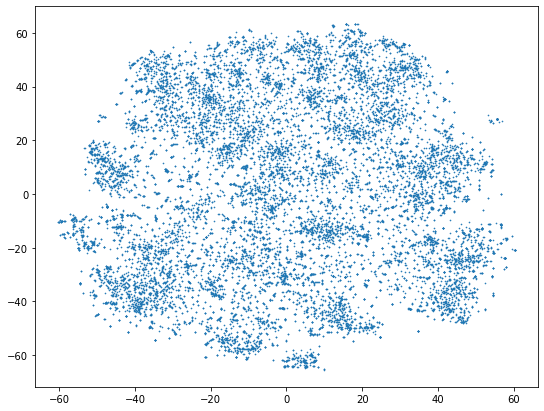

In [57]:
fig = plt.figure(figsize=(9,7))
plot = plt.scatter(points2d[:,0], points2d[:,1], s=0.4)
plt.show()

In [58]:
np.count_nonzero(np.sum(points2d**2, axis=1))

15970

In [59]:
np.count_nonzero(np.sum(points**2, axis=1)) 

15970

In [60]:
def inertia_score(points):
    inertias = []
    for i in range(2, 27):
        kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto").fit(points)
        inertias.append(kmeans.inertia_)
    return inertias

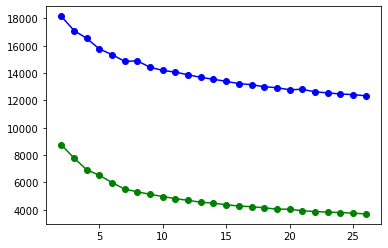

In [61]:
pca = PCA(10).fit_transform(points)
y = inertia_score(points)
x = [_ for _ in range(2, len(y)+2)]
fig = plt.figure()
plot = plt.plot(x, y, '-o', color='blue')
y = inertia_score(pca)
plot2 = plt.plot(x, y, '-o', color='green')
plt.show()

In [62]:
def silhouette(points):
    scores = []
    for i in range(2, 27):
        kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto").fit(points)
        scores.append(silhouette_score(points, kmeans.labels_))
    return scores

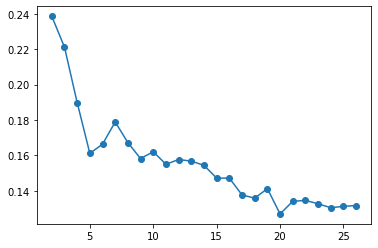

In [63]:
y = silhouette(pca)
x = [_ for _ in range(2, len(y)+2)]
plot1 = plt.plot(x, y, '-o')
plt.show()

## KMeans

In [64]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init=10).fit(points)

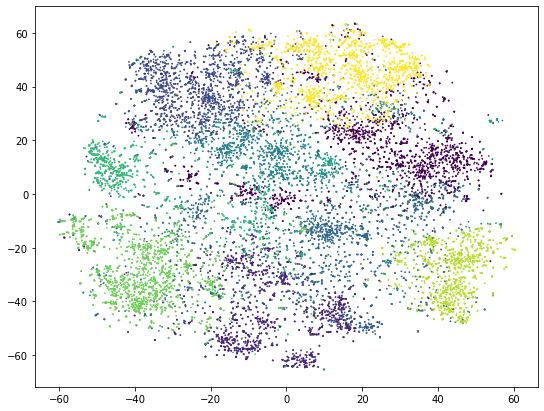

In [65]:
fig = plt.figure(figsize=(9,7))
plot = plt.scatter(points2d[:,0], points2d[:,1], c=kmeans.labels_, s=0.6)
plt.show()

## GaussianMixture

In [66]:
from sklearn.mixture import GaussianMixture

In [67]:
gm = GaussianMixture(n_components=6, random_state=0).fit_predict(points)

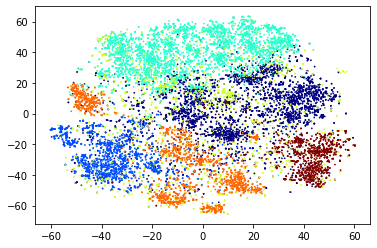

In [68]:
plot = plt.scatter(points2d[:,0], points2d[:,1], c=gm, s=0.5, cmap='jet')
plt.show()

In [69]:
gm = GaussianMixture(n_components=20, random_state=0).fit_predict(points)

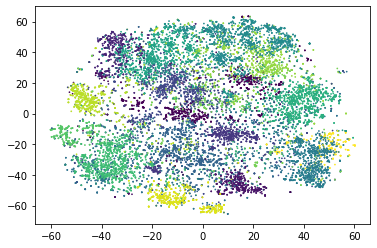

In [70]:
plot = plt.scatter(points2d[:,0], points2d[:,1], c=gm, s=0.5)
plt.show()

## DBSCAN

In [77]:
from sklearn.cluster import DBSCAN

In [78]:
db = DBSCAN(eps=0.5, min_samples=5, metric='precomputed', n_jobs=-1).fit_predict(distance_matrix)

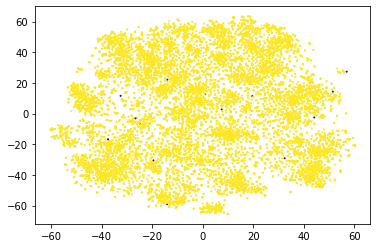

In [79]:
plt.scatter(points2d[:,0], points2d[:,1], c=db, s=1)

## AgglomerativeClustering

In [74]:
from sklearn.cluster import AgglomerativeClustering

In [75]:
ac = AgglomerativeClustering(n_clusters=10, linkage='average', memory='./cache', metric='precomputed')
ac.fit_predict(distance_matrix)

C:\Users\marty\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:1046: UserWarning: Persisting input arguments took 2.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  out = memory.cache(tree_builder)(


array([6, 6, 6, ..., 6, 6, 6], dtype=int64)

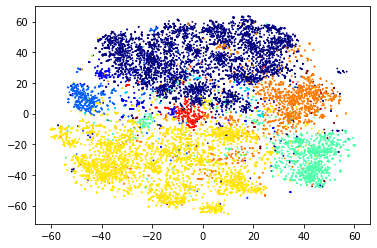

In [76]:
plt.scatter(points2d[:,0], points2d[:,1], c=ac.labels_, s=0.6, cmap='jet')